In [1]:
%load_ext autoreload
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn enhances the aesthetics of matplotlib plots
import pandas as pd
import xarray as xr
import seaborn as sns
import math
import matplotlib.colors
import warnings
import os
# sns.set()

from tempest import casestudy
from tempest import grid
from tempest import storm_tracker
from tempest import joint_distrib
from tempest import handler
from tempest.plots.hist import simple_hist

In [2]:
### WINTER + SUMMER###
settings_paths = [
  "settings/obs_winter_30d.yaml", 
  "settings/obs_summer_30d.yaml",
  "settings/arpege_winter_30d.yaml", 
  "settings/arpege_summer_30d.yaml", 
  "settings/ifs_winter_30d.yaml" , 
  "settings/ifs_summer_30d.yaml" , 
  "settings/mpas_winter_30d.yaml", 
  "settings/mpas_summer_30d.yaml", 
  "settings/screamv1_winter_30d.yaml",
  "settings/screamv1_summer_30d.yaml", 
  "settings/sam_winter_30d.yaml", 
  "settings/sam_summer_30d.yaml", 
  "settings/um_winter_30d.yaml",
  "settings/um_summer_30d.yaml",
  "settings/xshield_winter_30d.yaml" , 
  "settings/fv3_summer_30d.yaml", 
  "settings/geos_winter_30d.yaml", 
  "settings/grist_winter_30d.yaml", 
  "settings/nicam_summer_30d.yaml", 
               ]

nd = 4
hdlrs = [handler.Handler(settings_path) for settings_path in settings_paths]
css = [casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False) for hdlr in hdlrs]
grs = [grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False) for cs in css]
jds_all = [joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", 
        nbpd = 20,  nd=nd, overwrite = False, dist_mask = False) for gr in grs]

Data loaded from /scratchx/mcarenso/tempest/OBS_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/OBS_Summer_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/ARPEGE_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/ARPEGE_Summer_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/IFS_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/IFS_Summer_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/MPAS_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/MPAS_Summer_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/SCREAMv1_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/SCREAMv1_Summer_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/SAM_Winter_lowRes_Tropics/va

In [3]:
def make_jds(gr, var_id, overwrite = False):
    """
    added 95 and 97 to grid Prec calculus, but need to relaunch everything..
    What is the sensitivity to nbpd ? and nd ? 
    """
    cond_alpha_values = ["00", "01", "05", "10", "20", "25", "33", "40", "50", "60", "62", "64", "65", 
                         "66", "67", "68", "69", "70", "71", "72", "73", "74", "75", "76", "77", "78", 
                         "79", "80", "81", "82", "83", "84", "85", "86", "87", "88", "89", "90", "91", 
                         "92", "93", "94", "95", "96", "97", "98", "99"
                         ]
    jds = []
    # Create the base joint  distribution
    jd_xy = joint_distrib.JointDistribution(gr, None, var_id_1=var_id, var_id_2=var_id, nbpd=20, nd=nd, overwrite=False, dist_mask=False, verbose=False)
    jds.append(jd_xy)
    # Create joint distributions for each cond_alpha value
    for alpha in cond_alpha_values:
        jd = joint_distrib.JointDistribution(gr, None, var_id_1=var_id, var_id_2=f"cond_alpha_{alpha}_Prec", nbpd=20, nd=nd, overwrite=False, dist_mask=False, verbose=False)
        jds.append(jd)
    # Create the max_Prec joint distribution
    jd_max = joint_distrib.JointDistribution(gr, None, var_id_1=var_id, var_id_2="max_Prec", nbpd=20, nd=nd, overwrite=False, dist_mask=False)
    jds.append(jd_max)

    return jds[::-1] ##because cond_alpha_values actually corresponds to 1-alpha of the alpha in the paper ~~!>O_._O<!~~

def make_mis(jds, rank_threshold_int=20):
    mi, mi_pos, mi_neg = [], [], []
    for jd in jds:
        jd.compute_joint_density(jd.sample1, jd.sample2, method='default')
        out = jd.mutual_information(rank_threshold_int=rank_threshold_int)
        mi.append(out[0])
        mi_pos.append(out[1]) #unusednd
        mi_neg.append(out[2]) #unused
    return mi

In [4]:
rank_threshold_int = 20  ## carefull this is an int that corresponds to the selected nbpd * nd in jds initiation

convective_var_ids = [
    "mean_unweighted_Prec",
    "convective_01_Prec", 
    "convective_02_Prec", 
    "convective_03_Prec", 
    "convective_04_Prec", "convective_05_Prec", "convective_06_Prec", "convective_08_Prec", 
    "convective_10_Prec", 
    "convective_12_Prec", 
    "convective_15_Prec",
    "convective_20_Prec", "convective_25_Prec", 
    "convective_30_Prec", 
    "convective_40_Prec", 
    "convective_50_Prec"
]

mis_per_model = []

for i in range(len(settings_paths)):
    gr = grs[i]
    all_mis = {}
    all_jds = {}
    filename = f"mis_rank_start_{rank_threshold_int}_nd_{nd}.npy"
    filepath = os.path.join(gr.casestudy.data_out, filename)
    print(gr.casestudy.name)
    if os.path.exists(filepath): # False for overwrite, but it takes 2h :)
        mis = np.load(filepath)
    else : 
        for var_id in convective_var_ids:
            print(var_id)
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=RuntimeWarning)
                jds = make_jds(gr, var_id, False)
                all_jds[var_id] = jds
                all_mis[var_id] = make_mis(jds, rank_threshold_int = rank_threshold_int)

        # Creating a list of MIs
        mis = [all_mis[var_id] for var_id in convective_var_ids]
        np.save(filepath, mis)
    mis_per_model.append(mis)

OBS_Winter_lowRes_Tropics
OBS_Summer_lowRes_Tropics
ARPEGE_Winter_lowRes_Tropics
ARPEGE_Summer_lowRes_Tropics
IFS_Winter_lowRes_Tropics
IFS_Summer_lowRes_Tropics
MPAS_Winter_lowRes_Tropics
MPAS_Summer_lowRes_Tropics
SCREAMv1_Winter_lowRes_Tropics
SCREAMv1_Summer_lowRes_Tropics
SAM_Winter_lowRes_Tropics
SAM_Summer_lowRes_Tropics
UM_Winter_lowRes_Tropics
UM_Summer_lowRes_Tropics
XSHiELD_Winter_lowRes_Tropics
FV3_Summer_lowRes_Tropics
GEOS_Winter_lowRes_Tropics
GRIST_Winter_lowRes_Tropics
NICAM_Summer_lowRes_Tropics


In [5]:
alphas =["0.01", "0.02", "0.03", "0.04","0.05", "0.06", "0.07", "0.08", "0.09","0.1", 
         "0.11", "0.12", "0.13", "0.14", "0.15", "0.16", "0.17", "0.18", "0.19", "0.2", 
         "0.21", "0.22", "0.23", "0.24", "0.25", "0.26", "0.27", "0.28", "0.29",  "0.3", 
         "0.31", "0.32", "0.33", "0.34", "0.35", "0.36", "0.38", "0.4", "0.5", "0.6", "0.67", "0.75", "0.8", "0.9", "0.95", "0.99", "1"]

model_names = ["OBS", "ARPEGE", "IFS", "MPAS", "SCREAMv1", "SAM", "UM", "XSHiELD"+"\n"+"FV3", "GEOS", "GRIST", "NICAM"]

alpha_argmin = []
alpha_argmax = []

for settings, mis in zip(settings_paths, mis_per_model): 
    print(settings, alphas[np.argmin(mis[0][1:-1]/mis[0][-1])], alphas[np.argmax(mis[8][1:-1]/mis[0][-1])])
    alpha_argmin.append(alphas[np.argmin(mis[0][1:-1]/mis[0][-1])]) #mis[0] is with mean_unweighted_Prec
    alpha_argmax.append(alphas[np.argmax(mis[8][1:-1]/mis[8][-1])]) #mis[8] is with convective_10_Prec

settings/obs_winter_30d.yaml 0.08 0.06
settings/obs_summer_30d.yaml 0.13 0.06
settings/arpege_winter_30d.yaml 0.19 0.27
settings/arpege_summer_30d.yaml 0.2 0.22
settings/ifs_winter_30d.yaml 0.4 0.3
settings/ifs_summer_30d.yaml 0.4 0.29
settings/mpas_winter_30d.yaml 0.35 0.33
settings/mpas_summer_30d.yaml 0.08 0.01
settings/screamv1_winter_30d.yaml 0.21 0.35
settings/screamv1_summer_30d.yaml 0.18 0.33
settings/sam_winter_30d.yaml 0.2 0.4
settings/sam_summer_30d.yaml 0.13 0.4
settings/um_winter_30d.yaml 0.33 0.27
settings/um_summer_30d.yaml 0.4 0.3
settings/xshield_winter_30d.yaml 0.14 0.2
settings/fv3_summer_30d.yaml 0.14 0.29
settings/geos_winter_30d.yaml 0.3 0.25
settings/grist_winter_30d.yaml 0.18 0.31
settings/nicam_summer_30d.yaml 0.38 0.5


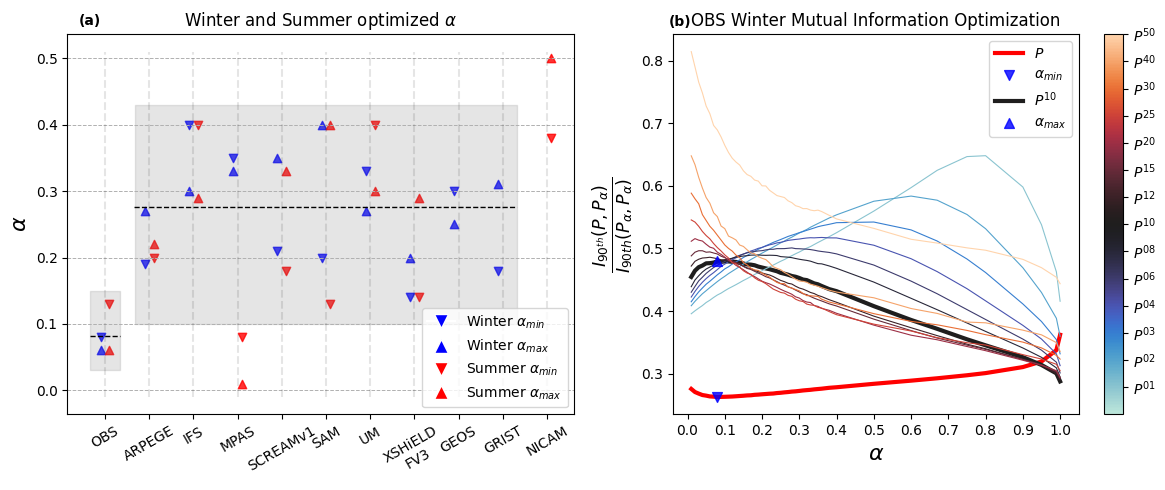

In [10]:
fig, axs = plt.subplots(1, 2, figsize = (12, 5))

ax = axs[0]
for j, jd in enumerate(jds_all): 
    model_name, season = jd.name.split("_")[0], jd.name.split("_")[1]
    if model_name == "FV3" or model_name == "XSHiELD":
        model_name = "XSHiELD"+"\n"+"FV3"
    i_model = model_names.index(model_name)
    if season == "Winter":
        ax.scatter([i_model-0.1], float(alpha_argmin[j]), color="b", label=model_name+"_"+season, alpha = 0.8, marker = "v") ## 10 is ^
        ax.scatter([i_model-0.1], float(alpha_argmax[j]), color="b", label=model_name+"_"+season, alpha = 0.8, marker = "^") ## 11 is v 
        ax.vlines([i_model], -0.01, 0.51, colors ="k", linestyles = "dashed", alpha = 0.1)
    if season == "Summer":
        ax.scatter([i_model+0.1], float(alpha_argmin[j]), color="r", label=model_name+"_"+season, alpha = 0.8, marker = "v")
        ax.scatter([i_model+0.1], float(alpha_argmax[j]), color="r", label=model_name+"_"+season, alpha = 0.8, marker = "^")        
        if model_name == "NICAM":
            ax.vlines([i_model], -0.01, 0.51, colors ="k", linestyles = "dashed", alpha = 0.1)

ax.fill_between([-0.33, 0.33], 0.03, 0.15, color='gray', alpha=0.2)
ax.fill_between([0.67, len(jds_all)//2+0.33], 0.1, .43, color='gray', alpha=0.2)
ax.plot([0.67, len(jds_all)//2+0.33], [0.2753, 0.2753333], color='k', linestyle='--', linewidth=1)  # Adjust the y-value as needed
ax.plot([-0.33, 0.33], [0.0825, 0.0825], color='k', linestyle='--', linewidth=1)  # Adjust the y-value as needed



ax.set_xticks(np.arange(len(model_names)), model_names, rotation = 30)
ax.set_ylabel(r"$\alpha$", fontsize = 16)   
ax.set_title(r"Winter and Summer optimized $\alpha$")
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

# Creating custom legend
handles = [
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='b', markersize=10, label=r'Winter $\alpha_{min}$'),
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='b', markersize=10, label=r'Winter $\alpha_{max}$'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='r', markersize=10, label=r'Summer $\alpha_{min}$'),
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='r', markersize=10, label=r'Summer $\alpha_{max}$')
]

ax.legend(handles=handles, loc='lower right')
ax.text(-0.6, 0.55, "(a)", color = 'k', fontweight='bold')

ax = axs[1]

alphas =[float(alpha) for alpha in alphas]
labels = [
    r"$P$", r"$P^{01}$", r"$P^{02}$", r"$P^{03}$", r"$P^{04}$", r"$P^{06}$", r"$P^{08}$", r"$P^{10}$", 
    r"$P^{12}$", r"$P^{15}$", r"$P^{20}$", r"$P^{25}$", r"$P^{30}$", r"$P^{40}$", r"$P^{50}$"
]
#cmap
cmap = sns.color_palette("icefire", as_cmap=True)
values_and_boundaries = np.arange(0, 0.05 + 0.001, 0.001)
values = values_and_boundaries[1::2]
boundaries = values_and_boundaries[::2]
norm = plt.Normalize(vmin=0, vmax=len(labels) - 1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])


i_model = 0
gr= grs[i_model]
mis = mis_per_model[i_model]
jd = jds_all[i_model]

# Plot the first line with a distinct color and double line width
first_color = 'red'
ax.plot(alphas, mis[0][1:-1]/mis[0][-1], label=labels[0], color=first_color, linewidth=3.0, zorder = 1)
alpha_min = alphas[np.argmin(mis[0][1:-1]/mis[0][-1])]
mi_min = mis[0][1:-1][np.argmin(mis[0][1:-1]/mis[0][-1])]/mis[0][-1]
ax.scatter([alpha_min], mi_min, color="b", label=r"$\alpha_{min}$", alpha = 0.8, marker = "v", s=50, zorder = 10) ## 10 is ^

# Iterate starting from second line
for idx, (mi, label) in enumerate(zip(mis[1:], labels[1:]), start=1):
    color = cmap(norm(idx))
    if idx==7:
        ax.plot(alphas, mi[1:-1]/mi[-1], label = labels[7], color=color, linewidth=3.0, zorder = 1)
        alpha_max = float(alphas[np.argmax(mi[1:-1]/mi[-1])])
        mi_max = mi[1:-1][np.argmax(mi[1:-1]/mi[-1])]/mi[-1]        
        ax.scatter([alpha_max], mi_max, color="b", label=r"$\alpha_{max}$", alpha = 0.8, marker = "^", s=50, zorder =10) #
    else : 
        ax.plot(alphas, mi[1:-1]/mi[-1], color=color, linewidth=0.8)


ax.set_xlabel(r'$\alpha$', fontsize = 16)
ax.set_xticks(np.linspace(0, 1, 11)) #, rotation = 30
ax.set_ylabel(r'$\frac{I_{90^{th}}(P, P_{\alpha})}{I_{90th}(P_{\alpha}, P_{\alpha})}$', fontsize = 18)
ax.text(-0.05, 0.855, "(b)", color = 'k', fontweight='bold')

title = jd.name.split("_")[0] + " " + jd.name.split("_")[1]

ax.set_title(title + " Mutual Information Optimization")
ax.legend()

# Adding color bar
cbar = plt.colorbar(sm, ax=ax, ticks=range(1, len(labels)))
cbar.ax.set_yticklabels(labels[1:])

plt.tight_layout()
plt.show()

In [67]:
moy1 = 0
for i,a in enumerate(alpha_argmin[2:-1]):
    a = float(a)
    if i != 5 : 
        moy1+=a
moy1/=len(alpha_argmin[2:-2])

moy2 = 0
for i,a in enumerate(alpha_argmax[2:-1]):
    a = float(a)
    if i != 5 : moy2+=a
moy2/=len(alpha_argmax[2:-2])
(moy1+moy2)/2


0.2753333333333333

In [ ]:
moy1 = 0
for i,a in enumerate(alpha_argmin[:2]):
    a = float(a)
    if i != 5 : 
        moy1+=a
moy1/=len(alpha_argmin[2:-2])

moy2 = 0
for i,a in enumerate(alpha_argmax[:2]):
    a = float(a)
    if i != 5 : moy2+=a
moy2/=len(alpha_argmax[2:-2])
(moy1+moy2)/2


In [75]:
(0.12+0.13+0.08)/4

0.0825